Importing Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
import mediapipe as mp

Keypoints using Mediapipe Holistic

In [2]:
mp_holistic = mp.solutions.holistic  # Holistic Model for detections
mp_drawing = mp.solutions.drawing_utils # Drawing utilities for drawing detections

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Color Conversion BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make Prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #Color Conversion RGB to BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)   # Draw Face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)       # Draw Pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw Left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw Right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    
    # Draw Face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # dot color
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))# line color
    
    # Draw Pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(99,153,20), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(18,100,181), thickness=2, circle_radius=4))       
    
    # Draw Left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=4))
    
    # Draw Right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(168,97,25), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(180,56,21), thickness=2, circle_radius=4)) 

In [6]:
cap = cv2.VideoCapture(0)

# Access Mediapipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # read feed 
        ret, frame = cap.read()

        # Make Detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # show frame to screen
        cv2.imshow('OpenCV feed',image)

        # quit capturing
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # release camera        
    cap.release()

    # close all the windows
    cv2.destroyAllWindows()

In [7]:
len(results.face_landmarks.landmark)

468

In [8]:
len(results.pose_landmarks.landmark)

33

In [9]:
frame

array([[[  0,   5,   4],
        [ 10,  17,  16],
        [ 10,  17,  16],
        ...,
        [169, 170, 174],
        [168, 168, 174],
        [168, 168, 175]],

       [[  5,  14,  13],
        [ 11,  20,  19],
        [ 12,  22,  20],
        ...,
        [168, 169, 173],
        [167, 168, 173],
        [166, 166, 172]],

       [[  6,  18,  17],
        [  7,  19,  18],
        [  8,  21,  20],
        ...,
        [167, 168, 171],
        [166, 167, 170],
        [165, 166, 169]],

       ...,

       [[  1,  56,  73],
        [  0,  52,  69],
        [  0,  50,  67],
        ...,
        [ 95, 124, 122],
        [ 94, 122, 116],
        [ 99, 127, 118]],

       [[  3,  54,  73],
        [  0,  50,  69],
        [  0,  47,  68],
        ...,
        [100, 119, 124],
        [105, 122, 122],
        [116, 131, 130]],

       [[  5,  54,  74],
        [  1,  49,  70],
        [  1,  47,  70],
        ...,
        [ 92, 104, 115],
        [ 89,  99, 104],
        [ 96, 104, 107]]

In [10]:
draw_styled_landmarks(frame, results)

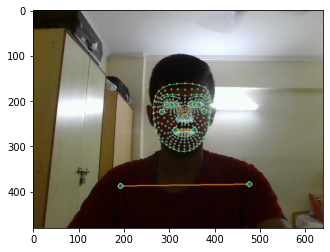

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract Keypoint Values

In [12]:
len(results.pose_landmarks.landmark)

33

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132) # 33*4
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63) # 21*3
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63) # 21*3
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404) # 468*3 
    return np.concatenate([pose, face, lh, rh])

In [14]:
extract_keypoints(results)

array([ 0.52434701,  0.48788166, -1.03540277, ...,  0.        ,
        0.        ,  0.        ])

In [15]:
len(extract_keypoints(results))

1662

Setup Folders for Collections

In [16]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello','thanks','iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# 30 frames in each video 
sequence_length = 30

In [17]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

Collect Keypoint Values for Training and Testing 

In [18]:
cap = cv2.VideoCapture(0)

# Access Mediapipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # loop through actions
    for action in actions:
        
        # loop through sequences aka videos
        for sequence in range(no_sequences):
            
            # loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # read feed 
                ret, frame = cap.read()

                # Make Detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Collection and wait logic
                if frame_num == 0:
                    cv2.putText(image, "Starting Collection", (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f"Collecting frames for {action} Video Number {sequence}", (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                    # show frame to screen
                    cv2.imshow('OpenCV feed',image)
                else:
                    cv2.putText(image, f"Collecting frames for {action} Video Number {sequence}", (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # show frame to screen
                    cv2.imshow('OpenCV feed',image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # quit capturing
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    quit()

    # release camera        
    cap.release()

    # close all the windows
    cv2.destroyAllWindows()

Preprocess Data and Create Labels and Features

In [75]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [76]:
label_map = {label:num for num,label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [77]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [78]:
np.array(sequences).shape   # 90 videos with 30 frames each with 1662 keypoints per each fram 

(90, 30, 1662)

In [79]:
np.array(labels).shape

(90,)

In [80]:
x = np.array(sequences)
x.shape

(90, 30, 1662)

In [81]:
y = to_categorical(labels).astype(int)
y.shape

(90, 3)

In [82]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [84]:
x_train.shape

(85, 30, 1662)

In [85]:
x_test.shape

(5, 30, 1662)

In [86]:
y_train.shape

(85, 3)

In [87]:
y_test.shape

(5, 3)

Build and Train LSTM Neural Network

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [89]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [112]:
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)),
    LSTM(128, return_sequences=True, activation='relu'),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(actions.shape[0], activation='softmax')
])

In [113]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [93]:
model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 0s 107ms/step - loss: 17.8852 - categorical_accuracy: 0.3059
Epoch 2/2000
3/3 [==============================] - 0s 94ms/step - loss: 27.2337 - categorical_accuracy: 0.4706
Epoch 3/2000
3/3 [==============================] - 0s 94ms/step - loss: 75.8362 - categorical_accuracy: 0.2941
Epoch 4/2000
3/3 [==============================] - 0s 95ms/step - loss: 36.2894 - categorical_accuracy: 0.3059
Epoch 5/2000
3/3 [==============================] - 0s 101ms/step - loss: 27.2449 - categorical_accuracy: 0.3529
Epoch 6/2000
3/3 [==============================] - 0s 97ms/step - loss: 35.3019 - categorical_accuracy: 0.4118
Epoch 7/2000
3/3 [==============================] - 0s 95ms/step - loss: 55.5729 - categorical_accuracy: 0.2000
Epoch 8/2000
3/3 [==============================] - 0s 102ms/step - loss: 43.2655 - categorical_accuracy: 0.2941
Epoch 9/2000
3/3 [==============================] - 0s 91ms/step - loss: 106.1894 - categorical_accur

3/3 [==============================] - 0s 92ms/step - loss: 1.0290 - categorical_accuracy: 0.5882
Epoch 146/2000
3/3 [==============================] - 0s 89ms/step - loss: 1.0255 - categorical_accuracy: 0.6706
Epoch 147/2000
3/3 [==============================] - 0s 93ms/step - loss: 1.0310 - categorical_accuracy: 0.6118
Epoch 148/2000
3/3 [==============================] - 0s 94ms/step - loss: 1.0530 - categorical_accuracy: 0.4588
Epoch 149/2000
3/3 [==============================] - 0s 92ms/step - loss: 1.0348 - categorical_accuracy: 0.5176
Epoch 150/2000
3/3 [==============================] - 0s 90ms/step - loss: 1.0363 - categorical_accuracy: 0.5529
Epoch 151/2000
3/3 [==============================] - 0s 92ms/step - loss: 1.0341 - categorical_accuracy: 0.5412
Epoch 152/2000
3/3 [==============================] - 0s 95ms/step - loss: 1.0172 - categorical_accuracy: 0.5176
Epoch 153/2000
3/3 [==============================] - 0s 91ms/step - loss: 1.0419 - categorical_accuracy: 0.529

3/3 [==============================] - 0s 89ms/step - loss: 0.6676 - categorical_accuracy: 0.7529
Epoch 290/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.6336 - categorical_accuracy: 0.7529
Epoch 291/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.6256 - categorical_accuracy: 0.7882
Epoch 292/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.6271 - categorical_accuracy: 0.7765
Epoch 293/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.6233 - categorical_accuracy: 0.7765
Epoch 294/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.6187 - categorical_accuracy: 0.7765
Epoch 295/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.6258 - categorical_accuracy: 0.7647
Epoch 296/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.6140 - categorical_accuracy: 0.8118
Epoch 297/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.6179 - categorical_accuracy: 0.788

3/3 [==============================] - 0s 99ms/step - loss: 0.5723 - categorical_accuracy: 0.7765
Epoch 434/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.5167 - categorical_accuracy: 0.8235
Epoch 435/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.5030 - categorical_accuracy: 0.8118
Epoch 436/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.4943 - categorical_accuracy: 0.8588
Epoch 437/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.4710 - categorical_accuracy: 0.9059
Epoch 438/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.6009 - categorical_accuracy: 0.7529
Epoch 439/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.5089 - categorical_accuracy: 0.8235
Epoch 440/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.4660 - categorical_accuracy: 0.8941
Epoch 441/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.5275 - categorical_accuracy: 0.823

3/3 [==============================] - 0s 96ms/step - loss: 0.3727 - categorical_accuracy: 0.8824
Epoch 578/2000
3/3 [==============================] - 0s 126ms/step - loss: 0.3609 - categorical_accuracy: 0.9294
Epoch 579/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.3402 - categorical_accuracy: 0.9059
Epoch 580/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.3157 - categorical_accuracy: 0.9412
Epoch 581/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.3069 - categorical_accuracy: 0.9294
Epoch 582/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.3216 - categorical_accuracy: 0.9294
Epoch 583/2000
3/3 [==============================] - 0s 124ms/step - loss: 0.3658 - categorical_accuracy: 0.8706
Epoch 584/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.3521 - categorical_accuracy: 0.9176
Epoch 585/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.3495 - categorical_accuracy: 0

3/3 [==============================] - 0s 107ms/step - loss: 0.3069 - categorical_accuracy: 0.9294
Epoch 722/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.3168 - categorical_accuracy: 0.9176
Epoch 723/2000
3/3 [==============================] - 0s 120ms/step - loss: 0.3813 - categorical_accuracy: 0.8471
Epoch 724/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.4587 - categorical_accuracy: 0.8000
Epoch 725/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.2676 - categorical_accuracy: 0.9647
Epoch 726/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.3102 - categorical_accuracy: 0.9059
Epoch 727/2000
3/3 [==============================] - 0s 85ms/step - loss: 0.3334 - categorical_accuracy: 0.9059
Epoch 728/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.2696 - categorical_accuracy: 0.9294
Epoch 729/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.2736 - categorical_accuracy: 0

3/3 [==============================] - 0s 113ms/step - loss: 0.2948 - categorical_accuracy: 0.9059
Epoch 866/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.2760 - categorical_accuracy: 0.9412
Epoch 867/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.2801 - categorical_accuracy: 0.8824
Epoch 868/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.3271 - categorical_accuracy: 0.9294
Epoch 869/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.3296 - categorical_accuracy: 0.8706
Epoch 870/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.3148 - categorical_accuracy: 0.9176
Epoch 871/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.2832 - categorical_accuracy: 0.9059
Epoch 872/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.3067 - categorical_accuracy: 0.9059
Epoch 873/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.3174 - categorical_accuracy: 0

3/3 [==============================] - 0s 92ms/step - loss: 0.2357 - categorical_accuracy: 0.9176
Epoch 1010/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.2326 - categorical_accuracy: 0.9412
Epoch 1011/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.2267 - categorical_accuracy: 0.9412
Epoch 1012/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.2338 - categorical_accuracy: 0.9412
Epoch 1013/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.2236 - categorical_accuracy: 0.9529
Epoch 1014/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.2599 - categorical_accuracy: 0.8941
Epoch 1015/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.2507 - categorical_accuracy: 0.9176
Epoch 1016/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.2771 - categorical_accuracy: 0.8824
Epoch 1017/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.2563 - categorical_accura

3/3 [==============================] - 0s 80ms/step - loss: 0.2198 - categorical_accuracy: 0.9294
Epoch 1152/2000
3/3 [==============================] - 0s 81ms/step - loss: 0.2166 - categorical_accuracy: 0.9529
Epoch 1153/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.1892 - categorical_accuracy: 0.9412
Epoch 1154/2000
3/3 [==============================] - 0s 113ms/step - loss: 0.1945 - categorical_accuracy: 0.9412
Epoch 1155/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.1798 - categorical_accuracy: 0.9412
Epoch 1156/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.1850 - categorical_accuracy: 0.9529
Epoch 1157/2000
3/3 [==============================] - 0s 112ms/step - loss: 0.1807 - categorical_accuracy: 0.9529
Epoch 1158/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.2081 - categorical_accuracy: 0.9412
Epoch 1159/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.2139 - categorical_acc

3/3 [==============================] - 0s 111ms/step - loss: 0.4417 - categorical_accuracy: 0.8353
Epoch 1294/2000
3/3 [==============================] - 0s 132ms/step - loss: 0.3028 - categorical_accuracy: 0.8941
Epoch 1295/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.2622 - categorical_accuracy: 0.8941
Epoch 1296/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.2586 - categorical_accuracy: 0.9412
Epoch 1297/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.2264 - categorical_accuracy: 0.9412
Epoch 1298/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.2304 - categorical_accuracy: 0.9176
Epoch 1299/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.2078 - categorical_accuracy: 0.9412
Epoch 1300/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.1981 - categorical_accuracy: 0.9412
Epoch 1301/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.1978 - categorical_acc

3/3 [==============================] - 0s 94ms/step - loss: 0.1621 - categorical_accuracy: 0.9529
Epoch 1436/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.1758 - categorical_accuracy: 0.9529
Epoch 1437/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.2041 - categorical_accuracy: 0.9294
Epoch 1438/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.2027 - categorical_accuracy: 0.9529
Epoch 1439/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.2224 - categorical_accuracy: 0.9412
Epoch 1440/2000
3/3 [==============================] - 0s 78ms/step - loss: 0.1882 - categorical_accuracy: 0.9529
Epoch 1441/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.2073 - categorical_accuracy: 0.9294
Epoch 1442/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.2051 - categorical_accuracy: 0.9529
Epoch 1443/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.1801 - categorical_accurac

Epoch 1507/2000
3/3 [==============================] - 0s 111ms/step - loss: 0.2569 - categorical_accuracy: 0.8941
Epoch 1508/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.2858 - categorical_accuracy: 0.8941
Epoch 1509/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.2957 - categorical_accuracy: 0.8824
Epoch 1510/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.2954 - categorical_accuracy: 0.8824
Epoch 1511/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.2313 - categorical_accuracy: 0.9176
Epoch 1512/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.2230 - categorical_accuracy: 0.9176
Epoch 1513/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.1987 - categorical_accuracy: 0.9294
Epoch 1514/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.1734 - categorical_accuracy: 0.9529
Epoch 1515/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.1641 - 

KeyboardInterrupt: 

In [94]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_16 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

Make Predictions

In [96]:
res = model.predict(x_test)

1/1 [==============================] - 0s 29ms/step


In [105]:
actions[np.argmax(res[4])]

'thanks'

In [107]:
actions[np.argmax(y_test[4])]

'thanks'

In [108]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [109]:
y_train

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0,

Save Weights

In [110]:
model.save('actions.h5')

In [111]:
del model

In [115]:
model.load_weights('actions.h5')

Evaluation using Confusion Matrix and Accuracy

In [116]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [123]:
y_predicted = model.predict(x_train)

3/3 [==============================] - 0s 18ms/step


In [124]:
y_true = np.argmax(y_train, axis=1).tolist()
y_predicted = np.argmax(y_predicted, axis=1).tolist()

In [119]:
y_predicted

[1, 1, 1, 1, 1]

In [120]:
y_true

[1, 1, 1, 1, 1]

In [125]:
multilabel_confusion_matrix(y_true, y_predicted)

array([[[52,  3],
        [ 0, 30]],

       [[60,  0],
        [ 3, 22]],

       [[55,  0],
        [ 0, 30]]], dtype=int64)

In [126]:
accuracy_score(y_true, y_predicted)

0.9647058823529412

Test in Real Time

In [132]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [178]:
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)

# Access Mediapipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # read feed 
        ret, frame = cap.read()

        # Make Detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Predection Logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
    
        # Vizualizing Logic
        if res[np.argmax(res)] > threshold:
            if len(sentence) > 0:
                if(actions[np.argmax(res)] != sentence[-1]):
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        
        if len(sentence) > 5:
            sentence = sentence[-5:]
            
        # Viz Probabilities
        image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640,40), (245, 117, 69), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # show frame to screen
        cv2.imshow('OpenCV feed',image)

        # quit capturing
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # release camera        
    cap.release()

    # close all the windows
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step
thanks
1/1 [==============================] - 0s 17ms/step
thanks
1/1 [==============================] - 0s 6ms/step
thanks
1/1 [==============================] - 0s 18ms/step
thanks
1/1 [==============================] - 0s 18ms/step
thanks
1/1 [==============================] - 0s 16ms/step
thanks
1/1 [==============================] - 0s 17ms/step
thanks
1/1 [==============================] - 0s 15ms/step
thanks
1/1 [==============================] - 0s 28ms/step
thanks
1/1 [==============================] - 0s 17ms/step
thanks
1/1 [==============================] - 0s 13ms/step
thanks
1/1 [==============================] - 0s 21ms/step
thanks
1/1 [==============================] - 0s 18ms/step
thanks
1/1 [==============================] - 0s 8ms/step
thanks
1/1 [==============================] - 0s 11ms/step
thanks
1/1 [==============================] - 0s 17ms/step
thanks
1/1 [==============================] - 0s 3ms/step
thanks


1/1 [==============================] - 0s 27ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
